# Модуль 2
## 2.1 Сравнение нескольких алгоритмов на сессиях

In [1]:
# подгузка необходимых модулей
import pandas as pd
import numpy as np
from scipy import sparse

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка предобработанных данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

matrix_train = sparse.load_npz('new_features_train.npz')
matrix_test = sparse.load_npz('new_features_test.npz')

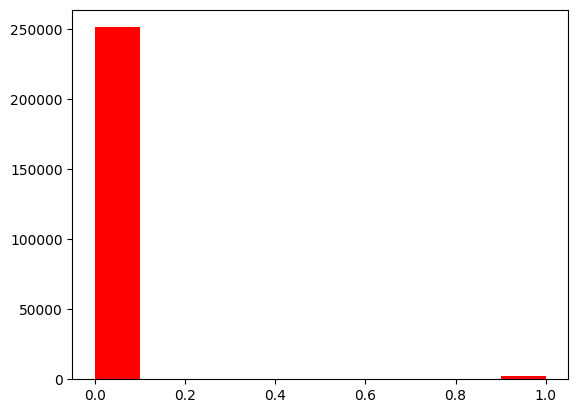

In [3]:
# посмотрим на распределение целевой переменной
import matplotlib.pyplot as plt

train_df['target'].hist(color='red')
plt.grid(False);

В данных наблюдается дисбаланс классов. Поэтому необходимо использовать при разбиении данных на обучающую и валидационную выборки параметр stratify, чтобы добиться одинакового соотношения классов в обеих выборках.

In [4]:
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler

X = train_df.drop(['target'], axis=1)
y = train_df['target']

# стандартизируем данные
X_scaled = StandardScaler().fit_transform(X)
test_df_scaled = StandardScaler().fit_transform(test_df)

# переводим в вид разряженной матрицы
X_csr = hstack([csr_matrix(X_scaled), matrix_train]) 
test_csr = hstack([csr_matrix(test_df_scaled), matrix_test])
X_csr

<253561x32784 sparse matrix of type '<class 'numpy.float64'>'
	with 7742295 stored elements in Compressed Sparse Row format>

In [5]:
# разобьем на матрицы признаков-предикторов и целевую переменную полученные наборы
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_csr, y, stratify=y, test_size=.3)

Для оценивания вероятностей того, что объект принадлежит к определённому классу, необходимо использовать в качестве метрики площадь под кривой приёмника (roc_auc_score).

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(probas, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, probas) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.plot(fpr, tpr, color="darkorange");
    plt.title(f"ROC_AUC: {round(roc_auc_score(y_true, probas), 3)}")

Попробуем несколько моделей. В качестве первой модели, которая способна оценивать вероятности классов, используем логистическую регрессию.

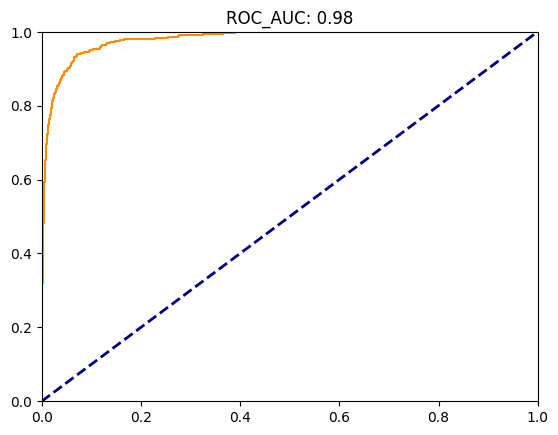

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
plot_roc_curve(log_reg.predict_proba(X_val)[:, 1], y_val)

Модель логистической регрессии показала отличные результаты! Попробуем построить ансамбль методом бэггинга на основе модели логистической регрессии.

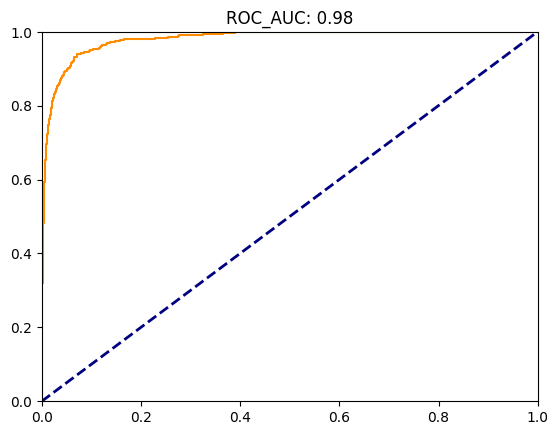

In [8]:
from sklearn.ensemble import BaggingClassifier

bagg_clf = BaggingClassifier(estimator=LogisticRegression(solver='liblinear'), n_estimators=100,
                             bootstrap=False, n_jobs=-1)
bagg_clf.fit(X_train, y_train)
plot_roc_curve(bagg_clf.predict_proba(X_val)[:, 1], y_val)

Прироста качества не неблюдается, поэтому можно выбрать модель попроще. Принимается решение использовать модель логистической регрессии.

## 2.2 Гиперпараметрическая оптимизация модели
После выбора модели необходимо оптимизировать её под решаемую задачу, настраивая гиперпараметры. Используем метод решетчатого поиска с перекрёстной проверкой для оптимизации параметров.

In [9]:
from sklearn.model_selection import GridSearchCV

# сетка параметров модели, которые необходимо подобрать
model_params = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [0.1, 1, 1.3, 1.4, 1.5, 2, 5, 10],
    'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(estimator=LogisticRegression(solver='liblinear', random_state=2023),
                          param_grid=model_params, scoring='roc_auc', cv=5, n_jobs=-1,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search.best_params_}\nЛучший результат: {grid_search.best_score_}")

/home/agat.local/s.bulganin/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучшие параметры: {'C': 2, 'class_weight': None, 'penalty': 'l2'}
Лучший результат: 0.9746561072414185


Итак, лучшими параметрами для модели логистической регрессии оказались приведённые выше результаты.

Теперь посмотрим, как зависит качество обучения от параметра C, построив кривую валидации. А также проверим, не наблюдается ли переобучение или недообучение модели.

In [10]:
def plot_validation_curve(model, X, y, 
                          param_name, param_range):
    from sklearn.model_selection import validation_curve
    train_scores, valid_scores = validation_curve(model, X, y, 
                                                  param_name=param_name, 
                                                  param_range=param_range,
                                                  scoring='roc_auc', n_jobs=-1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    
    plt.plot(param_range, train_mean, label="Training Score", color="blue")
    plt.plot(param_range, valid_mean, label="Validation Score", color="red")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="lightblue")
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, color="pink")

    plt.xlabel(param_name)
    plt.ylabel("Качество классификации")
    plt.legend(loc="best")
    plt.title("Кривая валидации");
    
def plot_learning_curve(model, X, y, train_sizes):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, 
                                                             train_sizes=train_sizes, 
                                                             scoring='roc_auc',
                                                             n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation Score", color="red")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="lightblue")
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="pink")

    plt.xlabel("Объем выборки")
    plt.ylabel("Качество классификации")
    plt.legend(loc="best")
    plt.title("Кривая обучения");

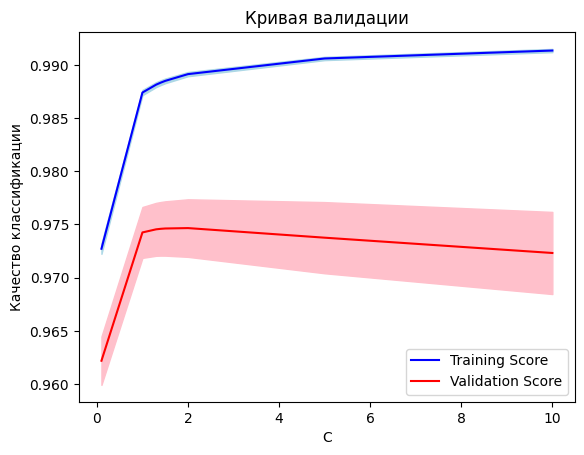

In [11]:
plot_validation_curve(LogisticRegression(solver='liblinear', penalty='l2', random_state=2023),
                    X_train, y_train, 'C', model_params['C'])

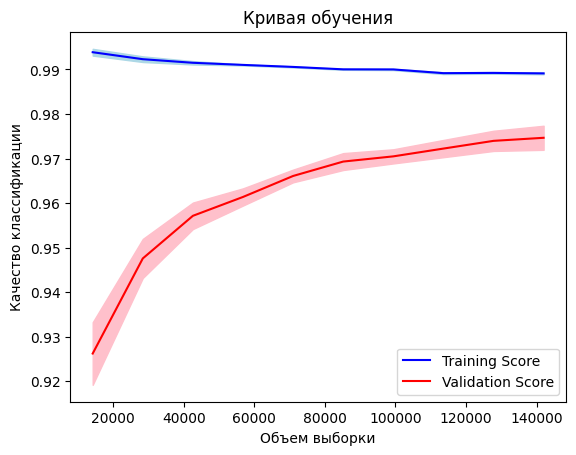

In [12]:
plot_learning_curve(LogisticRegression(solver='liblinear', C=2, 
                                       penalty='l2', random_state=2023),
                    X_train, y_train, 
                    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 2.3 Прогноз классификации для тестовой выборки

In [13]:
# показываю, что лежит в sample.csv
example = pd.read_csv('sample.csv')
example.head(5)

,session_id,target
0,1,0.948255
1,2,0.682483
2,3,0.502855
3,4,0.345556
4,5,0.889428


In [15]:
# лучшая модель
best_estimator = grid_search.best_estimator_
# вырабатываем предсказания 
preds_proba = best_estimator.predict_proba(test_csr)
preds_proba.shape

(82797, 2)

In [16]:
preds_df = pd.DataFrame({
    'session_id' : [i for i in range(1, preds_proba.shape[0] + 1)],
    'target' : preds_proba[:, 1]
})
preds_df.head(5)

,session_id,target
0,1,1.056346e-04
1,2,9.500670e-08
2,3,4.302008e-10
3,4,1.675445e-09
4,5,3.393755e-05


In [17]:
# сохраняю результат 
preds_df.to_csv('preds_lr.csv', index=False)